# Sales and Order Analysis  

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 12

In [85]:
ecom_data_df = pd.read_parquet("../data/olist_ecom.parquet")

In [86]:
display(ecom_data_df.sample(1))
ecom_data_df.info()

,index,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,time_to_approve,time_to_carrier,shipping_time,total_delivery_time,delivery_vs_estimate,Frequency,Monetary,Recency,R_score,F_score,M_score,RFM_score_string,RFM_score_composite,RFM_segment
1126,1126,30b766b012c5c55e2fba3726dc9d55bd,0f2ff54c1de35e0fef57c3cea4e1ed88,81220.0,curitiba,PR,991a833f96a0e2a37ff3edab5969e44d,delivered,2018-04-28 10:22:37,2018-04-28 20:53:23,2018-04-30 15:29:00,2018-05-07 15:32:51,2018-05-28,1.0,credit_card,4.0,48.13,1.0,7d018f8e4f93213ba7ad276e25fe20b1,3d871de0142ce09b7081e2b9d1733cb1,2018-05-04 20:53:23,29.9,18.23,relogios_presentes,56.0,361.0,2.0,350.0,40.0,10.0,25.0,0.438032,1.774734,7.002674,9.21544,-20.352187,1,48.13,135,4,1,1,411,6,Single Buyers (Recent & Moderate/Low M)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7475 entries, 0 to 7474
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   index                          7475 non-null   int64         
 1   customer_id                    7475 non-null   object        
 2   customer_unique_id             7475 non-null   object        
 3   customer_zip_code_prefix       6877 non-null   float64       
 4   customer_city                  7475 non-null   object        
 5   customer_state                 7475 non-null   object        
 6   order_id                       7475 non-null   object        
 7   order_status                   7475 non-null   object        
 8   order_purchase_timestamp       7475 non-null   datetime64[ns]
 9   order_approved_at              7475 non-null   datetime64[ns]
 10  order_delivered_carrier_date   7409 non-null   datetime64[ns]
 11  order_delivered_c

In [87]:
# --- AUTOMATED PLOT SAVING SETUP ---
PLOT_OUTPUT_DIR = "reports/figures"
os.makedirs(PLOT_OUTPUT_DIR, exist_ok=True)
print(f"Plot output directory created/ensured: {PLOT_OUTPUT_DIR}")

# Global counter for plot filenames
_plot_counter = 0
_plot_prefix = "plot"  # Default prefix for saved plots

# Store the original plt.show() function
_original_plt_show = plt.show


# Redefine plt.show() to save the plot before displaying
def custom_show(*args, **kwargs):
    global _plot_counter
    _plot_counter += 1

    # Construct filename based on counter and prefix
    filename = f"{_plot_prefix}_{_plot_counter}.png"
    filepath = os.path.join(PLOT_OUTPUT_DIR, filename)

    # Ensure tight_layout is applied for current figure before saving
    # bbox_inches='tight' helps prevent labels from being cut off
    plt.gcf().tight_layout()
    plt.savefig(filepath, bbox_inches="tight")
    print(f"Plot saved: {filepath}")

    # Call the original show function to display the plot
    _original_plt_show(*args, **kwargs)

    # Close the figure after displaying and saving to free up memory
    plt.close()


# Overwrite plt.show() with our custom function
plt.show = custom_show
print("`plt.show()` has been redefined to automatically save plots.")

Plot output directory created/ensured: reports/figures
`plt.show()` has been redefined to automatically save plots.


## Overall Sales Volume & Value
---
- what is the total order products?
- What is the total price and freight_value?
- What is the average order value (price + freight_value) per order?

In [88]:
total_order = ecom_data_df["order_id"].nunique()
total_revenue = ecom_data_df["price"].sum()
total_freight_value = ecom_data_df["freight_value"].sum()
avg_order = ecom_data_df.groupby("price")["freight_value"].sum().mean()
total_sales = total_revenue + total_freight_value

In [89]:
print(f"total order products: {total_order:,.0f}")
print(f"total revenue sales: R$ {total_revenue:,.2f}")
print(f"total freight price: R$ {total_freight_value:,.2f}")
print(f"average order product price: R$ {avg_order:,.2f}")
print(f"total sales (price + freight price): R$ {total_sales:,.2f}")

total order products: 6,817
total revenue sales: R$ 914,077.08
total freight price: R$ 145,420.97
average order product price: R$ 93.46
total sales (price + freight price): R$ 1,059,498.05


## Monthly sales Trend

In [90]:
ecom_data_df["order_period"] = ecom_data_df["order_purchase_timestamp"].dt.to_period(
    "M"
)
monthly_orders = (
    ecom_data_df.groupby("order_period")["order_id"].nunique().reset_index()
)
monthly_orders["order_period"] = monthly_orders["order_period"].astype(str)

In [118]:
display(monthly_orders.rename(columns={"order_id": "number_orders"}))

,order_period,number_orders
0,2016-10,27
1,2016-11,2
2,2017-01,59
3,2017-02,108
4,2017-03,176
5,2017-04,164
6,2017-05,252
7,2017-06,203
8,2017-07,271
9,2017-08,297


Make plot

Plot saved: reports/figures/plot_1.png


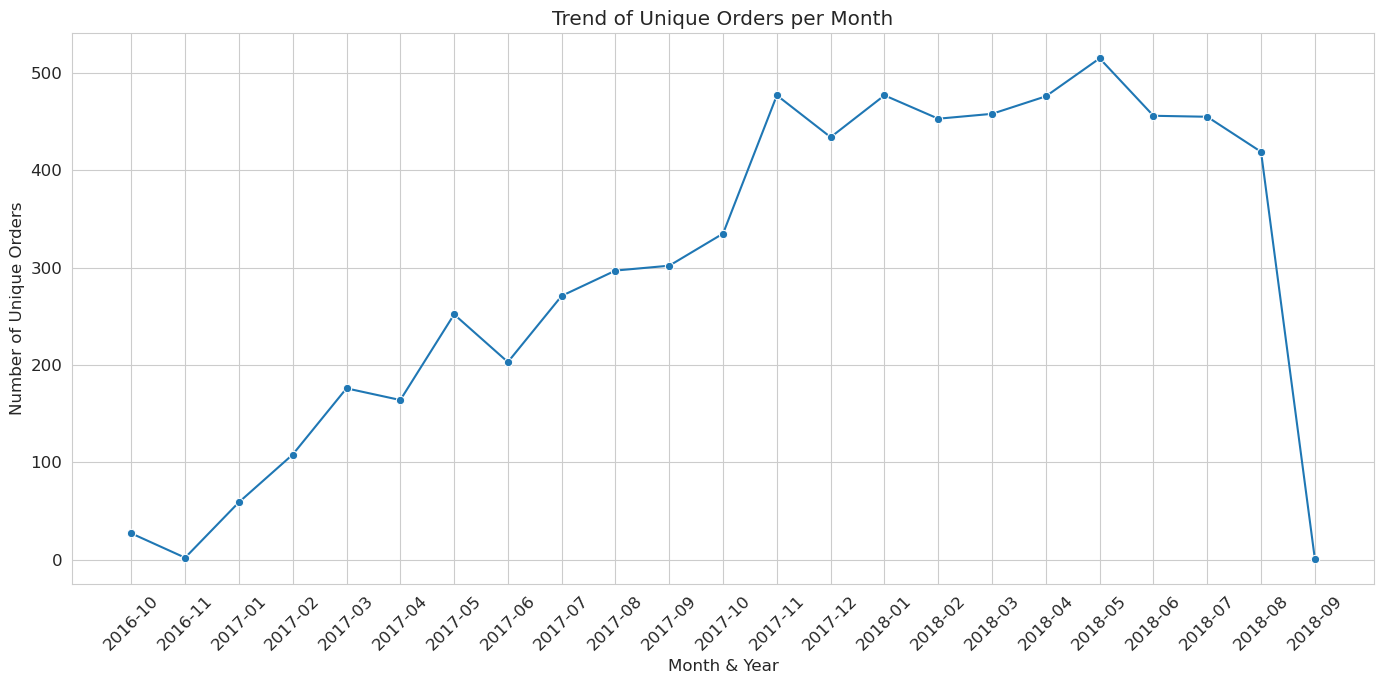

In [92]:
plt.figure(figsize=(14, 7))
sns.lineplot(x="order_period", y="order_id", data=monthly_orders, marker="o")
plt.title("Trend of Unique Orders per Month")
plt.xlabel("Month & Year")
plt.ylabel("Number of Unique Orders")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Monthly sales Trend (total product price)

In [93]:
monthly_revenue = ecom_data_df.groupby("order_period")["price"].sum().reset_index()
monthly_revenue["order_period"] = monthly_revenue["order_period"].astype(str)

In [119]:
display(monthly_revenue)

,order_period,price
0,2016-10,4928.66
1,2016-11,105.90
2,2017-01,7484.09
3,2017-02,13226.43
4,2017-03,26971.02
5,2017-04,18700.57
6,2017-05,36381.80
7,2017-06,28933.87
8,2017-07,37152.81
9,2017-08,39209.35


Make lineplot

Plot saved: reports/figures/plot_2.png


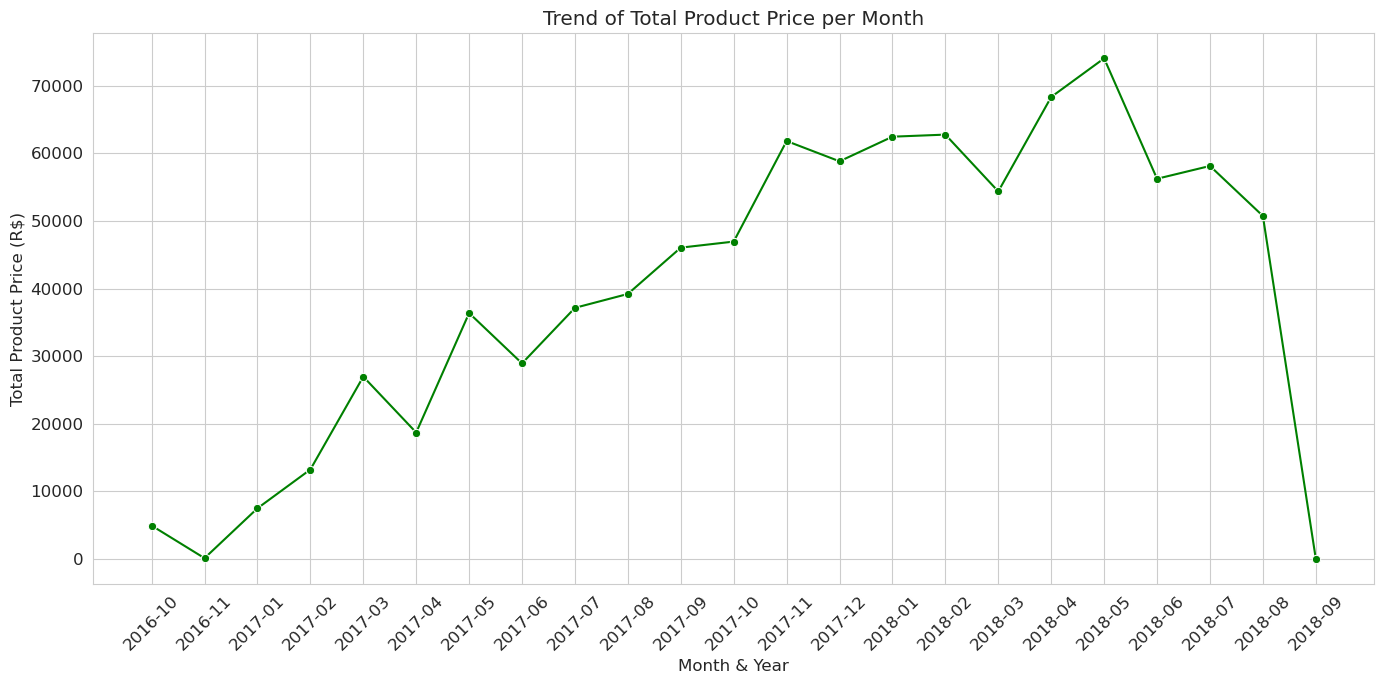

In [95]:
plt.figure(figsize=(14, 7))
sns.lineplot(
    x="order_period", y="price", data=monthly_revenue, marker="o", color="green"
)
plt.title("Trend of Total Product Price per Month")
plt.xlabel("Month & Year")
plt.ylabel("Total Product Price (R$)")
plt.xticks(rotation=45)
plt.ticklabel_format(style="plain", axis="y")
plt.tight_layout()
plt.show()

## Sales Trend by Day of the Week

In [96]:
ecom_data_df["order_day"] = ecom_data_df["order_purchase_timestamp"].dt.day_name()
# Set explicit order for days of the week
day_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
ecom_data_df["order_day"] = pd.Categorical(
    ecom_data_df["order_day"], categories=day_order, ordered=True
)

daily_orders = ecom_data_df.groupby("order_day")["order_id"].nunique().reset_index()

/tmp/ipykernel_86526/3406402376.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_orders = ecom_data_df.groupby("order_day")["order_id"].nunique().reset_index()


In [120]:
display(daily_orders.rename(columns={"order_id": "number_orders"}))

,order_day,number_orders
0,Monday,1344
1,Tuesday,1218
2,Wednesday,1141
3,Thursday,180
4,Friday,135
5,Saturday,1393
6,Sunday,1406


Plot saved: reports/figures/plot_3.png


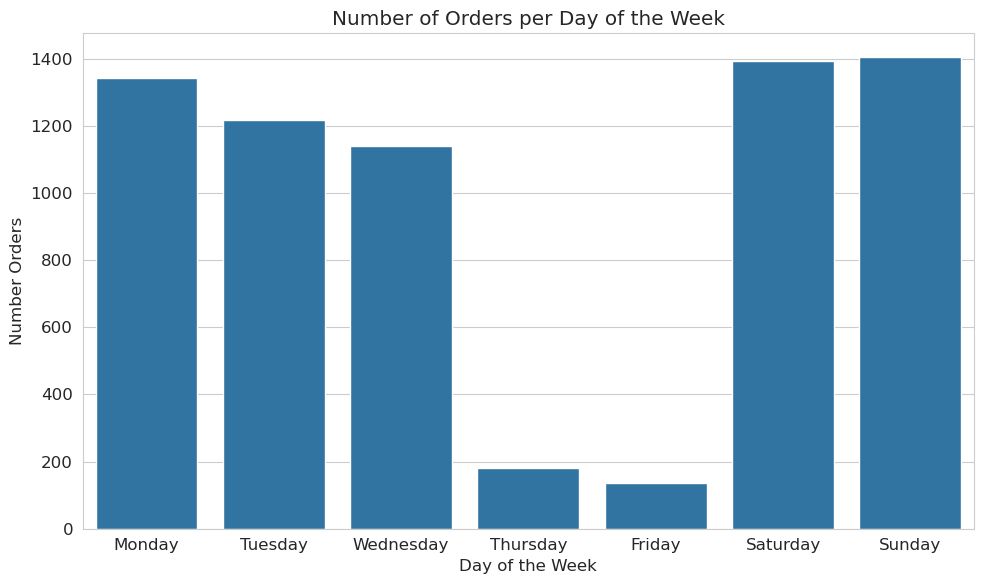

In [98]:
plt.figure(figsize=(10, 6))
sns.barplot(x="order_day", y="order_id", data=daily_orders)
plt.title("Number of Orders per Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number Orders")
plt.tight_layout()
plt.show()

## Sales Trend by hour of Purchase the Product

In [99]:
ecom_data_df["order_hour"] = ecom_data_df["order_purchase_timestamp"].dt.hour
hourly_orders = ecom_data_df.groupby("order_hour")["order_id"].nunique().reset_index()

In [122]:
display(hourly_orders.rename(columns={"order_id": "number_orders"}))

,order_hour,number_orders
0,0,41
1,1,66
2,2,80
3,3,144
4,4,131
5,5,216
6,6,268
7,7,354
8,8,575
9,9,701


Plot saved: reports/figures/plot_4.png


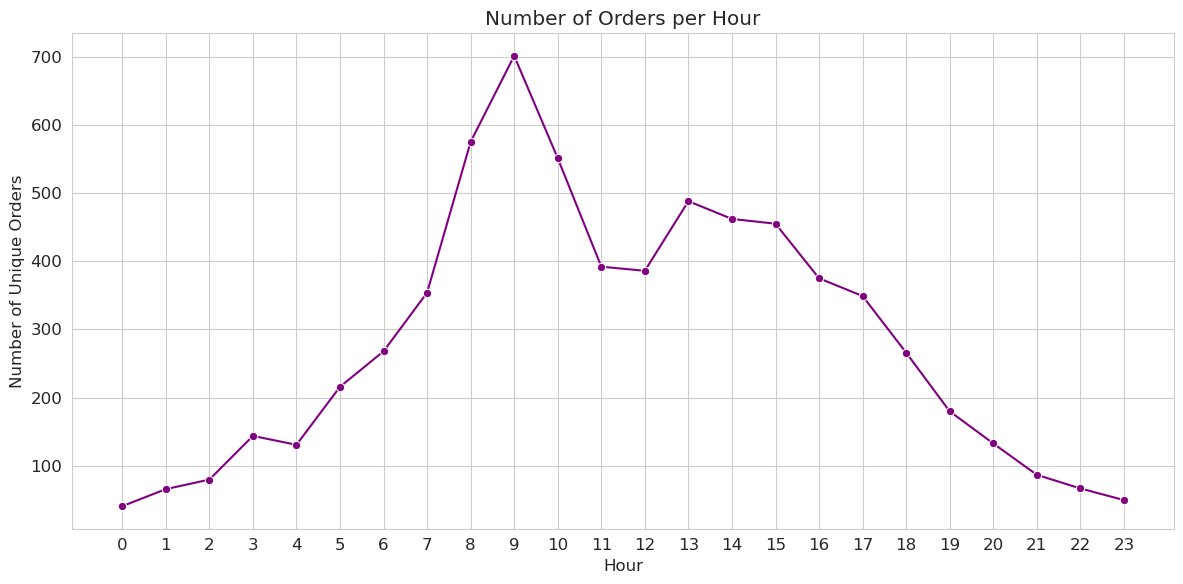

In [101]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    x="order_hour", y="order_id", data=hourly_orders, marker="o", color="purple"
)
plt.title("Number of Orders per Hour")
plt.xlabel("Hour")
plt.ylabel("Number of Unique Orders")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

## Distribution of Order Status

In [102]:
order_status = ecom_data_df["order_status"].value_counts(normalize=True) * 100

In [103]:
print(order_status)

order_status
delivered     98.220736
shipped        0.842809
canceled       0.428094
processing     0.267559
invoiced       0.240803
Name: proportion, dtype: float64


Plot saved: reports/figures/plot_5.png


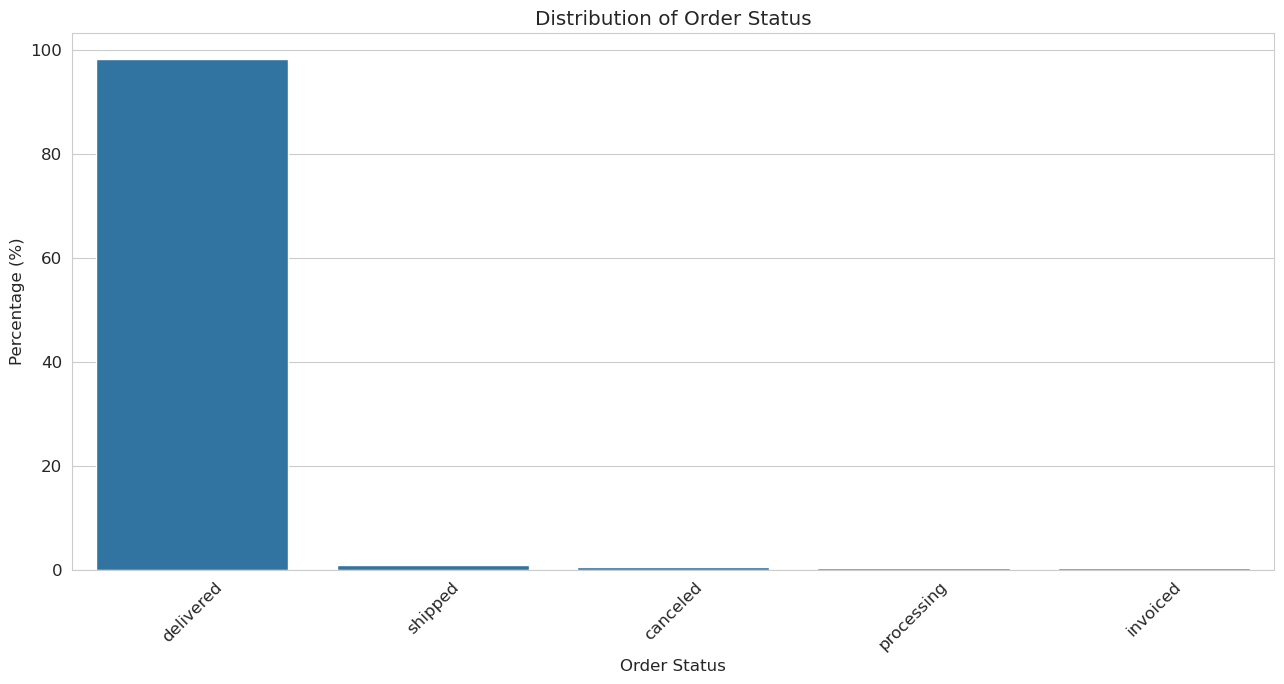

In [104]:
plt.figure(figsize=(13, 7))
sns.barplot(x=order_status.index, y=order_status.values)
plt.title("Distribution of Order Status")
plt.xlabel("Order Status")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Descriptive Statistics Numerical Columns

In [105]:
time_cols_for_analysis = [
    "time_to_approve",
    "time_to_carrier",
    "shipping_time",
    "total_delivery_time",
    "delivery_vs_estimate",
]

print("Descriptive Statistics for processing & delivery times (in days):")
ecom_data_df[time_cols_for_analysis].describe()

Descriptive Statistics for processing & delivery times (in days):


,time_to_approve,time_to_carrier,shipping_time,total_delivery_time,delivery_vs_estimate
count,7475.000000,7409.000000,7405.000000,7405.000000,6966.000000
mean,-0.586679,2.870067,9.214076,11.489083,-11.500280
std,3.256887,3.319170,8.546189,8.598062,10.243293
min,-62.357442,-9.341262,-11.980544,-11.021840,-74.158299
25%,-1.080521,0.959630,4.262025,6.491620,-16.409404
50%,0.044977,2.039225,7.098576,9.311343,-12.113848
75%,1.233038,3.418125,11.579884,13.939861,-6.996363
max,11.554028,64.570208,194.213009,196.425775,166.583380


## Distribution of Shipping Time (Using Histogram for Visualize)

Plot saved: reports/figures/plot_6.png


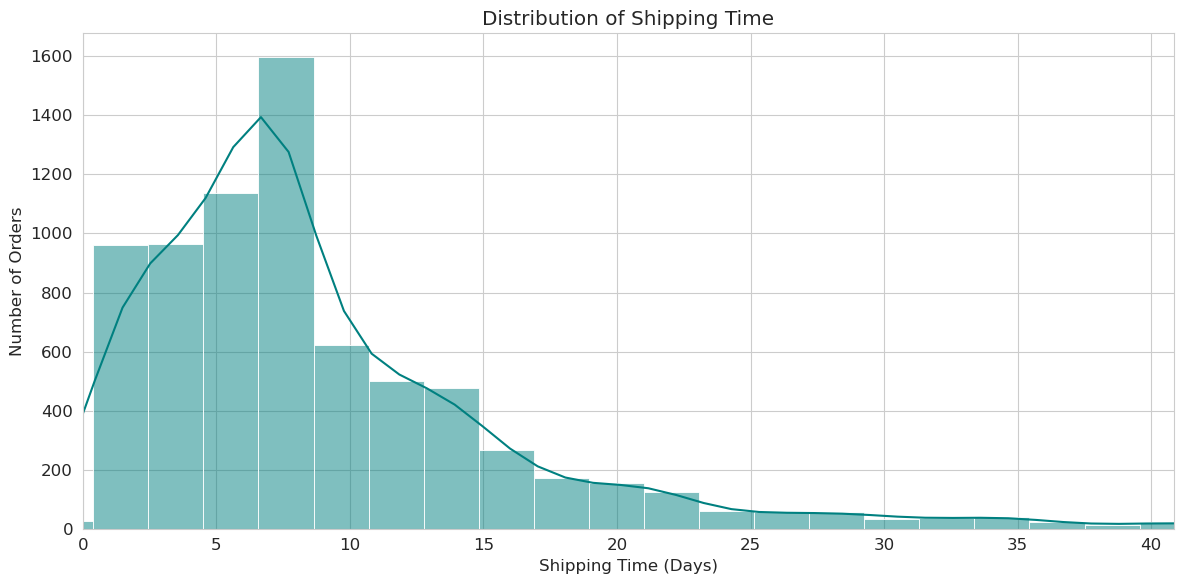

In [106]:
plt.figure(figsize=(12, 6))
sns.histplot(ecom_data_df["shipping_time"].dropna(), bins=100, kde=True, color="teal")
plt.title("Distribution of Shipping Time")
plt.xlabel("Shipping Time (Days)")
plt.ylabel("Number of Orders")
# Cap x-axis to 99th percentile to better visualize the main distribution, excluding extreme outliers
plt.xlim(0, ecom_data_df["shipping_time"].quantile(0.99))
plt.tight_layout()
plt.show()

## Delivery Performance vs Estimate

In [107]:
# set status delivery performace is on-time, Late, and Early
ecom_data_df["delivery_performance"] = "On-Time"

ecom_data_df.loc[ecom_data_df["delivery_vs_estimate"] > 0, "delivery_performance"] = (
    "Late"
)
ecom_data_df.loc[ecom_data_df["delivery_vs_estimate"] < 0, "delivery_performance"] = (
    "Early"
)

In [108]:
performance_counts = (
    ecom_data_df["delivery_performance"].value_counts(normalize=True) * 100
)

In [109]:
print(performance_counts)

delivery_performance
Early      86.020067
Late        7.170569
On-Time     6.809365
Name: proportion, dtype: float64


Plot saved: reports/figures/plot_7.png


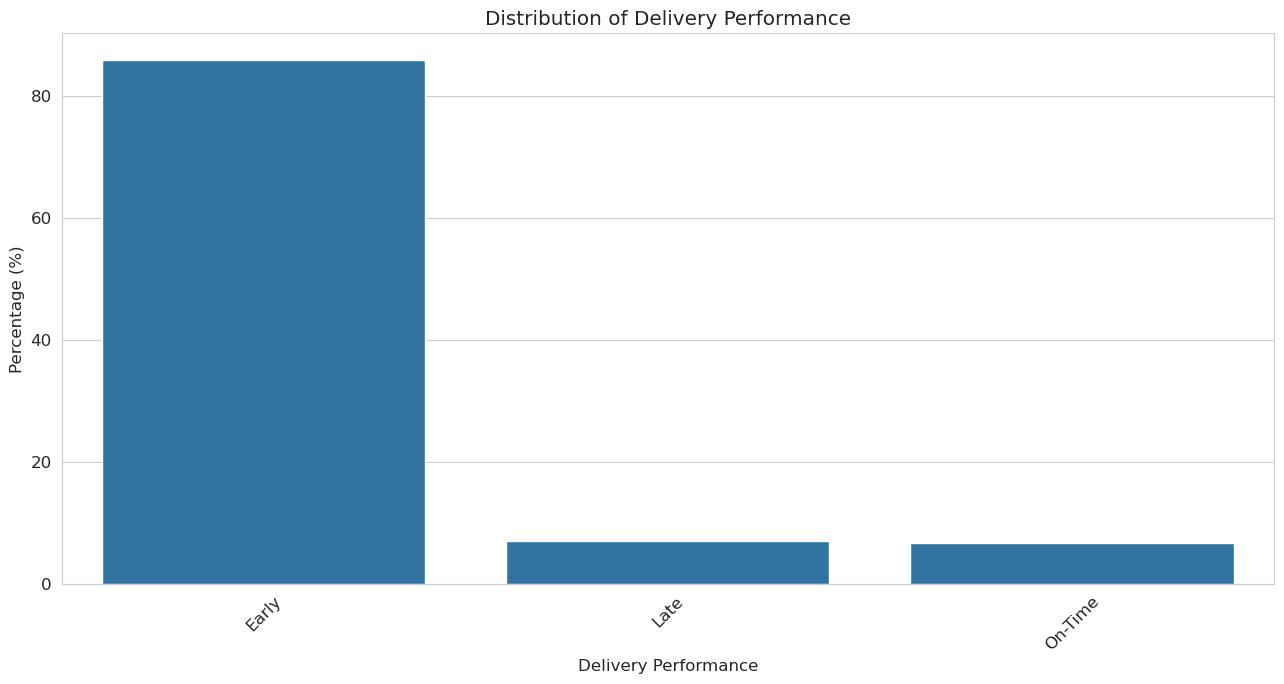

In [110]:
plt.figure(figsize=(13, 7))
sns.barplot(x=performance_counts.index, y=performance_counts.values)
plt.title("Distribution of Delivery Performance")
plt.xlabel("Delivery Performance")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Distribution of Freight Value

Plot saved: reports/figures/plot_8.png


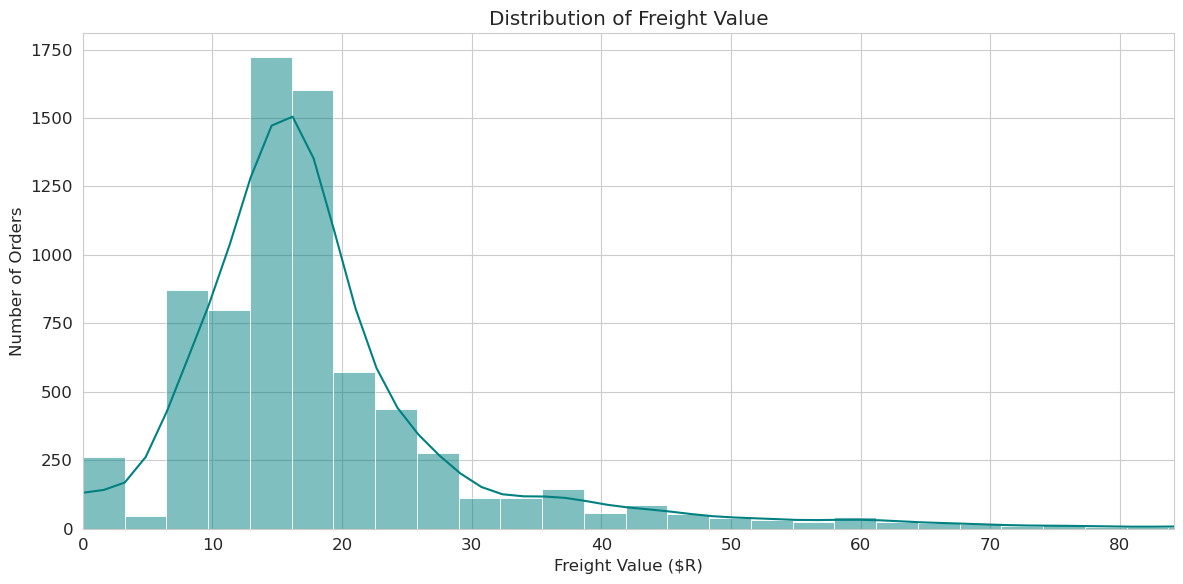

In [111]:
plt.figure(figsize=(12, 6))
sns.histplot(ecom_data_df["freight_value"].dropna(), bins=100, kde=True, color="teal")
plt.title("Distribution of Freight Value")
plt.xlabel("Freight Value ($R)")
plt.ylabel("Number of Orders")
# Cap x-axis to 99th percentile to better visualize the main distribution, excluding extreme outliers
plt.xlim(0, ecom_data_df["freight_value"].quantile(0.99))
plt.ticklabel_format(style="plain", axis="x")
plt.tight_layout()
plt.show()

## Average Freight Value per Customer State (Top 10)

In [112]:
avg_freight_by_state = (
    ecom_data_df.groupby("customer_state")["freight_value"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

In [128]:
display(avg_freight_by_state)

customer_state
RO    57.732500
RR    42.840000
AP    39.792500
PB    39.218333
PI    37.561200
AL    37.543939
SE    36.298000
RN    35.365714
MA    35.184167
AC    34.196250
Name: freight_value, dtype: float64

Plot saved: reports/figures/plot_9.png


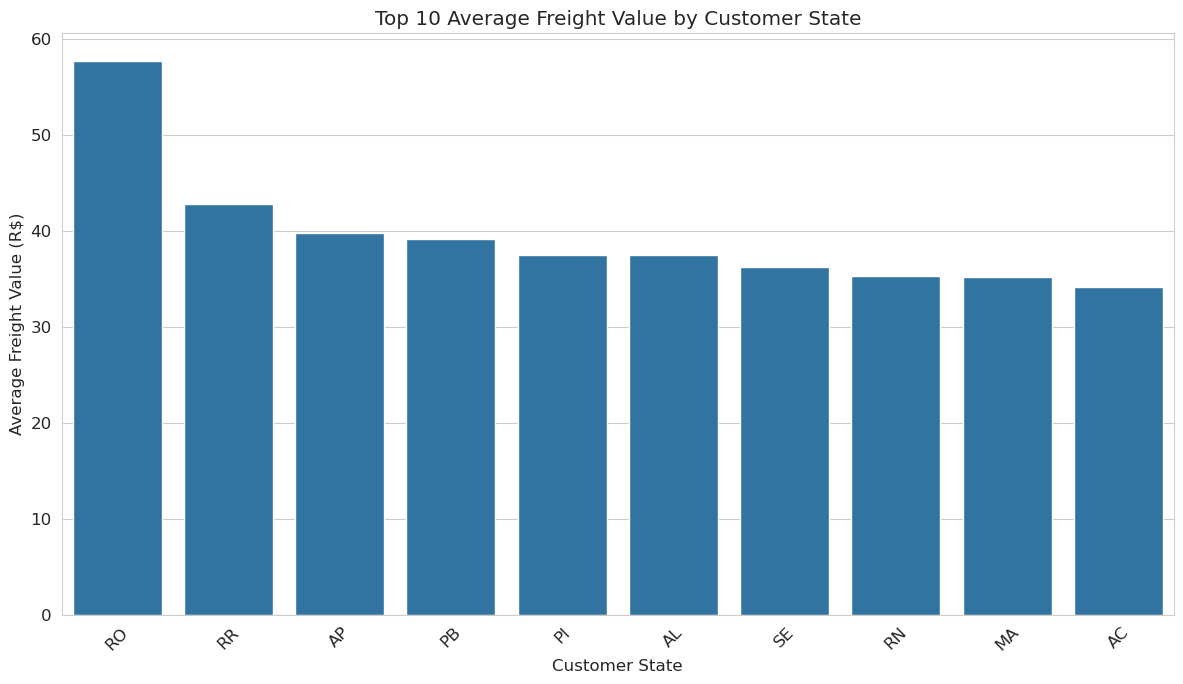

In [114]:
plt.figure(figsize=(12, 7))
sns.barplot(x=avg_freight_by_state.index, y=avg_freight_by_state.values)
plt.title("Top 10 Average Freight Value by Customer State")
plt.xlabel("Customer State")
plt.ylabel("Average Freight Value (R$)")
plt.xticks(rotation=45)
plt.ticklabel_format(style="plain", axis="y")
plt.tight_layout()
plt.show()